# TabNet Tutorial

Model Architecture from :
Arik, Sercan O., and Tomas Pfister. "Tabnet: Attentive interpretable tabular learning." arXiv preprint arXiv:1908.07442 (2019).

In [1]:
import pandas as pd
from tabnet.classifier import TabNetClassifier
from tabnet.autoencoder import TabNetAutoencoder
import tabnet_utils
from sklearn.model_selection import train_test_split
from datetime import datetime
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

Census Income is an academic dataset whose objective is to solve a problem of binary classification of the income for different individuals. Features are made up of demographic and job-related variables in different types.

In [2]:
data = pd.read_csv('../data/income/adult.data', delimiter=',', header=None, index_col=False,
                   names=['age', 'workclass', 'fnlwgt', 'education', 'education_num','marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week','native.country','Income'])

In [3]:
data

age          workclass  fnlwgt    education  education_num  \
0       39          State-gov   77516    Bachelors             13   
1       50   Self-emp-not-inc   83311    Bachelors             13   
2       38            Private  215646      HS-grad              9   
3       53            Private  234721         11th              7   
4       28            Private  338409    Bachelors             13   
...    ...                ...     ...          ...            ...   
32556   27            Private  257302   Assoc-acdm             12   
32557   40            Private  154374      HS-grad              9   
32558   58            Private  151910      HS-grad              9   
32559   22            Private  201490      HS-grad              9   
32560   52       Self-emp-inc  287927      HS-grad              9   

            marital.status          occupation    relationship    race  \
0            Never-married        Adm-clerical   Not-in-family   White   
1       Married-civ-spouse     Exec-managerial         Husband   White   
2                 Divorced   Handlers-cleaners   Not-in-family   White   
3       Married-civ-spouse   Handlers-cleaners         Husband   Black   
4       Married-civ-spouse      Prof-specialty            Wife   Black   
...                    ...                 ...             ...     ...   
32556   Married-civ-spouse        Tech-support            Wife   White   
32557   Married-civ-spouse   Machine-op-inspct         Husband   White   
32558              Widowed        Adm-clerical       Unmarried   White   
32559        Never-married        Adm-clerical       Own-child   White   
32560   Married-civ-spouse     Exec-managerial            Wife   White   

           sex  capital.gain  capital.loss  hours.per.week  native.country  \
0         Male          2174             0              40   United-States   
1         Male             0             0              13   United-States   
2         Male             0             0              40   United-States   
3         Male             0             0              40   United-States   
4       Female             0             0              40            Cuba   
...        ...           ...           ...             ...             ...   
32556   Female             0             0              38   United-States   
32557     Male             0             0              40   United-States   
32558   Female             0             0              40   United-States   
32559     Male             0             0              20   United-States   
32560   Female         15024             0              40   United-States   

       Income  
0       <=50K  
1       <=50K  
2       <=50K  
3       <=50K  
4       <=50K  
...       ...  
32556   <=50K  
32557    >50K  
32558   <=50K  
32559   <=50K  
32560    >50K  

[32561 rows x 15 columns]

# Data types conversions for tensorflow

This function converts the data types for tensorflow use and returns the types in order to create the dense representation of the feature columns.

In [4]:
data, types = tabnet_utils.convert_data_types(data)

# Classic train test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data.iloc[:,:-1],data.iloc[:,-1]
)

# Obtention of the feature columns dense representation 

In [6]:
columns = [tabnet_utils.get_feature(f, types[k]) for k, f in X_train.iteritems()]

# Pandas dataframe to tensorflow prefetch dataset transformation

In [7]:
train, test = tabnet_utils.df_to_dataset(X_train, y_train), tabnet_utils.df_to_dataset(X_test, y_test)

# Classic TabNet model

In [8]:
m = TabNetClassifier(feature_columns=columns, num_features=14, num_outputs=1, feature_dim=8, output_dim=8, num_decision_steps=3, relaxation_factor=1.2, 
                                  sparsity_coefficient=0.0001, batch_momentum=0.9, classifier_activation=tf.keras.activations.sigmoid)

logdir = "/tf/logs" + "/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

m.compile(tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
m.fit(train, epochs=100, validation_data=test, callbacks=[tensorboard_callback])

m.summary()

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6554 - accuracy: 0.6620 - val_loss: 0.6085 - val_accuracy: 0.7363
Epoch 2/100
1/1 [==============================] - 0s 157ms/step - loss: 0.6066 - accuracy: 0.7356 - val_loss: 0.5715 - val_accuracy: 0.7591
Epoch 3/100
1/1 [==============================] - 0s 159ms/step - loss: 0.5631 - accuracy: 0.7666 - val_loss: 0.5410 - val_accuracy: 0.7750
Epoch 4/100
1/1 [==============================] - 0s 142ms/step - loss: 0.5358 - accuracy: 0.7783 - val_loss: 0.5194 - val_accuracy: 0.7794
Epoch 5/100
1/1 [==============================] - 0s 149ms/step - loss: 0.5155 - accuracy: 0.7824 - val_loss: 0.5043 - val_accuracy: 0.7880
Epoch 6/100
1/1 [==============================] - 0s 147ms/step - loss: 0.5029 - accuracy: 0.7859 - val_loss: 0.4925 - val_accuracy: 0.7891
Epoch 7/100
1/1 [==============================] - 0s 149ms/step - loss: 0.4889 - accuracy: 0.7897 - val_loss: 0.4812 - val_accuracy: 0.7898
Epoch 8/100
1/1 

In [9]:
y_train_pred = m.predict(train).round()

accuracy_score(pd.Categorical(y_train).codes.astype('int32'),y_train_pred)

0.8385339885339885

In [10]:
y_test_pred = m.predict(test).round()

accuracy_score(pd.Categorical(y_test).codes.astype('int32'),y_test_pred)

0.8227490480284977

# Feature importances

Use of the learned masks to determine local and global feature importances for the model.

### Global importances

<AxesSubplot:title={'center':'Global Importances'}>

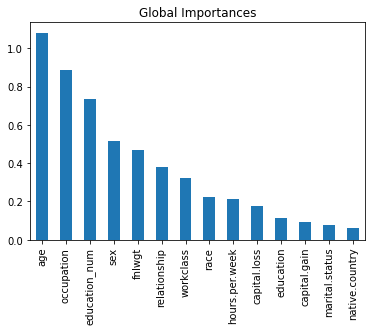

In [11]:
global_test = m.explain(dict(X_test)).numpy()
indices_test = global_test.mean(0).argsort()[::-1]
pd.Series(global_test.mean(0)[indices_test], index=X_test.columns[indices_test]).plot.bar(title='Global Importances')

<AxesSubplot:title={'center':'Individu 0 Importances'}>

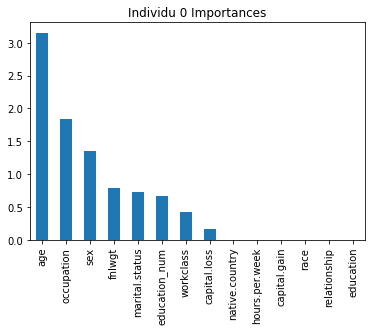

In [12]:
indices_test_individu0 = global_test[0].argsort()[::-1]
pd.Series(global_test[0][indices_test_individu0], index=X_test.columns[indices_test_individu0]).plot.bar(title='Individu 0 Importances')

### Step importances

In [13]:
steps_test = m.explain_steps(dict(X_test))

<AxesSubplot:title={'center':'Step 0 Individu 0 Importances'}>

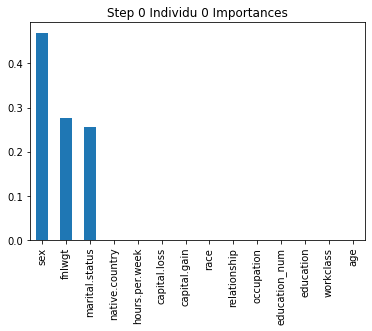

In [14]:
indices_test_step0_individu0 = steps_test[0].numpy()[0].argsort()[:][::-1]
pd.Series(steps_test[0].numpy()[0][indices_test_step0_individu0], index=X_test.columns[indices_test_step0_individu0]).plot.bar(title='Step 0 Individu 0 Importances')

<AxesSubplot:title={'center':'Step 1 Individu 0 Importances'}>

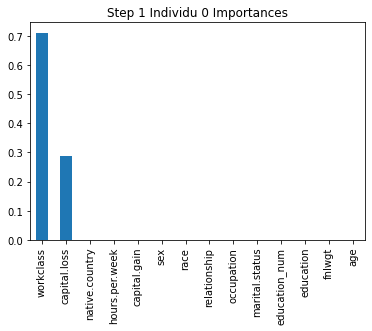

In [15]:
indices_test_step1_individu0 = steps_test[1].numpy()[0].argsort()[:][::-1]
pd.Series(steps_test[1].numpy()[0][indices_test_step1_individu0], index=X_test.columns[indices_test_step1_individu0]).plot.bar(title='Step 1 Individu 0 Importances')

<AxesSubplot:title={'center':'Step 2 Individu 0 Importances'}>

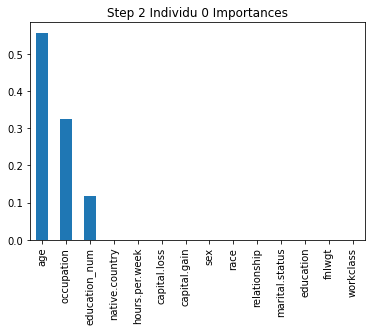

In [16]:
indices_test_step2_individu0 = steps_test[2].numpy()[0].argsort()[:][::-1]
pd.Series(steps_test[2].numpy()[0][indices_test_step2_individu0], index=X_test.columns[indices_test_step2_individu0]).plot.bar(title='Step 2 Individu 0 Importances')

# TabNet Auto-encoder

Self-supervised learning of the correlations between features accros large amounts of unlabelled data to improve the prediction performance on small amounts of labelled data.

In [17]:
train_ae, test_ae = tabnet_utils.df_to_dataset(X_train, X_train), tabnet_utils.df_to_dataset(X_test, X_test)

In [18]:
ae = TabNetAutoencoder(feature_columns=columns, num_features=14, num_outputs=1, feature_dim=8, output_dim=8, num_decision_steps=3, num_decision_steps_decoder=5,
                                     relaxation_factor=1.2, sparsity_coefficient=0.0001, batch_momentum=0.9)

logdir = "/tf/logs" + "/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

ae.compile(tf.keras.optimizers.Adam(0.01))
ae.fit(train_ae, epochs=100, validation_data=test_ae, callbacks=[tensorboard_callback])

ae.summary()

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 228743113080832.0000 - val_loss: 75472423616512.0000
Epoch 2/100
1/1 [==============================] - 0s 187ms/step - loss: 217859397517312.0000 - val_loss: 73068013682688.0000
Epoch 3/100
1/1 [==============================] - 0s 168ms/step - loss: 226908071526400.0000 - val_loss: 76899342614528.0000
Epoch 4/100
1/1 [==============================] - 0s 164ms/step - loss: 237552460103680.0000 - val_loss: 75373597425664.0000
Epoch 5/100
1/1 [==============================] - 0s 178ms/step - loss: 234563129311232.0000 - val_loss: 77720318902272.0000
Epoch 6/100
1/1 [==============================] - 0s 173ms/step - loss: 228056018976768.0000 - val_loss: 78086456475648.0000
Epoch 7/100
1/1 [==============================] - 0s 164ms/step - loss: 219035480358912.0000 - val_loss: 77999298838528.0000
Epoch 8/100
1/1 [==============================] - 0s 165ms/step - loss: 226457502613504.0000 - val_loss: 74465908097024.

No correlations between the features so the self-supervised learning is not very usefull in this case.

# Pretrained TabNet model

Use of the trained encoder from the auto-encoder to initialize the classifier (or regressor) encoder.

In [19]:
m_pretrained = TabNetClassifier(feature_columns=columns, num_features=14, num_outputs=1, feature_dim=8, output_dim=8, num_decision_steps=3, relaxation_factor=1.2, 
                                  sparsity_coefficient=0.0001, batch_momentum=0.9, pretrained_encoder=ae.layers[2], classifier_activation=tf.keras.activations.sigmoid)

logdir = "/tf/logs" + "/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

m_pretrained.compile(tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
m_pretrained.fit(train, epochs=100, validation_data=test, callbacks=[tensorboard_callback])

m_pretrained.summary()

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.6584 - accuracy: 0.5627 - val_loss: 0.6255 - val_accuracy: 0.6168
Epoch 2/100
1/1 [==============================] - 0s 180ms/step - loss: 0.6243 - accuracy: 0.6199 - val_loss: 0.6003 - val_accuracy: 0.6647
Epoch 3/100
1/1 [==============================] - 0s 156ms/step - loss: 0.6000 - accuracy: 0.6668 - val_loss: 0.5823 - val_accuracy: 0.7100
Epoch 4/100
1/1 [==============================] - 0s 168ms/step - loss: 0.5810 - accuracy: 0.7104 - val_loss: 0.5671 - val_accuracy: 0.7390
Epoch 5/100
1/1 [==============================] - 0s 144ms/step - loss: 0.5650 - accuracy: 0.7396 - val_loss: 0.5539 - val_accuracy: 0.7525
Epoch 6/100
1/1 [==============================] - 0s 144ms/step - loss: 0.5498 - accuracy: 0.7534 - val_loss: 0.5404 - val_accuracy: 0.7586
Epoch 7/100
1/1 [==============================] - 0s 144ms/step - loss: 0.5353 - accuracy: 0.7589 - val_loss: 0.5277 - val_accuracy: 0.7588
Epoch 8/100
1/1 

In [20]:
y_train_pred = m.predict(train).round()

accuracy_score(pd.Categorical(y_train).codes.astype('int32'),y_train_pred)

0.8385339885339885

In [21]:
y_test_pred = m.predict(test).round()

accuracy_score(pd.Categorical(y_test).codes.astype('int32'),y_test_pred)

0.8227490480284977